# Human Activity Recognition using TSFEL

On this example we will perform Human Activty Recognition using our library **Time Series Feature Extraction Library**.

To perform this example every cell must be executed. To do so click run ([  ]) in the top left of every cell.

The first step consists on importing the library. To do that press play. 

The import can take a few seconds, but the run button will change so that you know the import has started and ended.

A warning will appear to reset all runtimes before running, click to accept.

In [2]:
#@title Import Time Series Feature Extraction Library
import warnings
warnings.filterwarnings('ignore')
!pip install tsfel >/dev/null 2>&1
!pip install --upgrade -q gspread >/dev/null 2>&1
!pip install gspread oauth2client >/dev/null 2>&1
!pip install pandas >/dev/null 2>&1
!pip install scipy >/dev/null 2>&1
!pip install novainstrumentation >/dev/null 2>&1
!pip install pandas_profiling >/dev/null 2>&1
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip >/dev/null 2>&1

To check if everything was correctly imported, access "Files" (on the left side of the screen) and press "Refresh". If UCI HAR Dataset folder does not appear run Import Time Series Features library again.

---


In [24]:
# Import libraries
import secrets
import pandas as pd 
import numpy as np
import tsfel
import zipfile
from matplotlib import pyplot as plt 
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
sns.set()

# Unzip dataset
zip_ref = zipfile.ZipFile("UCI HAR Dataset.zip", 'r')
zip_ref.extractall()
zip_ref.close()

# Dataset

The dataset we will be using is open-source. It is provided by UCI and it was performed by 30 volunteers using a smartphone on the waist. It contains 6 activities: 

*   Walking
*   Standing
*   Sitting
*   Laying
*   Upstairs
*   Downstairs

The dataset used in this example can be found [here](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones).




In [25]:
#@title Data Preparation

# Load data
x_train_sig = np.loadtxt('UCI HAR Dataset/train/Inertial Signals/total_acc_x_train.txt', dtype='float32')
x_test_sig = np.loadtxt('UCI HAR Dataset/test/Inertial Signals/total_acc_x_test.txt', dtype='float32')
y_test = np.loadtxt('UCI HAR Dataset/test/y_test.txt')
y_train = np.loadtxt('UCI HAR Dataset/train/y_train.txt')
activity_labels = np.array(pd.read_csv('UCI HAR Dataset/activity_labels.txt', header=None, delimiter=' '))[:,1]

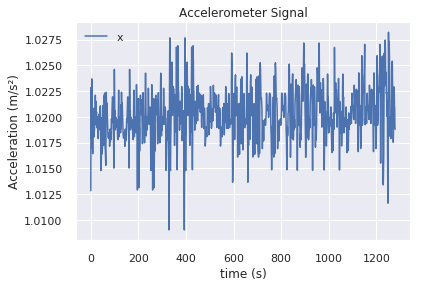

In [26]:
#@Signal Preview
%matplotlib inline
plt.figure()
plt_size = 10
plt.plot(np.concatenate(x_train_sig[0:plt_size],axis=0))
plt.xlabel("time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Accelerometer Signal")
plt.legend('x axis')
plt.show()

# Feature Extraction

Through **Feature Extraction** methodologies, the data is translated into a feature vecture containing information about the signal properties of each window. These properties can be classifier according to their domain as Time, Frequency and Statistical features and allow to characterise the signal in a compact way, enhancing its chracteristics. This features will be used as input to the machine learning classifier, thus, the chosen set of features can strongly influence the classification output.

The features to extract are defined in the [google sheet](https://docs.google.com/spreadsheets/d/10arCqT4iaVyl4IsDfbdTLf9tfagDM99X_JQZfY17ucg/edit?usp=sharing). Save a copy on your local drive and share it with featext@featext.iam.gserviceaccount.com.

**Change your google sheet file name and the googleSheet_name variable to your name so both have the same name.**

In [27]:
#@title Feature Extraction
googleSheet_name = "Insert Name"
# Extract excel info
cfg_file = tsfel.extract_sheet(googleSheet_name)

# Get features
X_train = tsfel.extract_features(cfg_file, x_train_sig, fs=100)
X_test = tsfel.extract_features(cfg_file, x_test_sig, fs=100)

*** Feature extraction started ***
*** Feature extraction finished ***
*** Feature extraction started ***
*** Feature extraction finished ***


# Feature Selection

After the sensor data is extracted, redundancies and noise should be removed. Thus, minimising the algorithm's error, time and computational complexity. 

In [28]:
#@title Removal of highly correlated features

# Concatenation of entire data
features = pd.concat([X_train, X_test])
# Highly correlated features are removed
features = tsfel.correlation_report(features)
X_train = features[:len(X_train)]
X_test = features[len(X_train):]

Do you wish to remove correlated features? Enter y/n: y
Removing 0_Autocorrelation
Removing 0_Mean
Removing 0_Mean absolute deviation
Removing 0_Mean absolute diff
Removing 0_Median
Removing 0_Median absolute deviation
Removing 0_Median absolute diff
Removing 0_Minimum peaks
Removing 0_Root mean square
Removing 0_Signal distance
Removing 0_Spectral centroid
Removing 0_Spectral roll-off
Removing 0_Spectral skewness
Removing 0_Spectral slope
Removing 0_Standard Deviation
Removing 0_Sum absolute diff
Removing 0_Variance


In [29]:
#@title Preview Features
st1 = pd.DataFrame(data=np.array(['c']*X_train.shape[1]).reshape(1,-1), columns = list(features.columns))
st2 = pd.DataFrame(data=np.array([' ']*X_train.shape[1]).reshape(1,-1), columns = list(features.columns))
feat_orange_header = pd.concat([st1, st2], axis=0, ignore_index=True)
_X_train = pd.concat([feat_orange_header, X_train], axis=0, ignore_index=True)
_X_test = pd.concat([feat_orange_header, X_test], axis=0, ignore_index=True)

labels = np.concatenate([y_train, y_test])
disc_labels = []
for l in labels:
  if l == 1:
    disc_labels.append('WALKING')
  elif l == 2:
    disc_labels.append('WALKING_UPSTAIRS')
  elif l == 3:
    disc_labels.append('WALKING_DOWNSTAIRS')
  elif l == 4:
    disc_labels.append('SITTING')
  elif l == 5:
    disc_labels.append('STANDING')
  elif l == 6:
    disc_labels.append('LAYING')
disc_y_train =  pd.DataFrame(data=disc_labels[:len(X_train)], columns=['Activity'])
disc_y_test =  pd.DataFrame(data=disc_labels[len(X_train):], columns=['Activity'])
disc_y_train = pd.concat([pd.DataFrame(data=['d','class'], columns=['Activity']), disc_y_train], axis=0, ignore_index=True)
disc_y_test = pd.concat([pd.DataFrame(data=['d','class'], columns=['Activity']), disc_y_test], axis=0, ignore_index=True)
orange_input_train= pd.concat([_X_train, disc_y_train], axis=1)
orange_input_test= pd.concat([_X_test, disc_y_test], axis=1)

orange_input_train.to_csv('orange_input_train.csv', sep=',', encoding='utf-8', index=False)
orange_input_test.to_csv('orange_input_test.csv', sep=',', encoding='utf-8', index=False)

features

,0_Curve distance,0_Fundamental frequency,0_Max power spectrum,0_Maximum frequency,0_Median frequency,0_Spectral decrease,0_Spectral kurtosis,0_Spectral maximum peaks,0_Spectral roll-on,0_Spectral spread,...,0_Interquartile range,0_Kurtosis,0_Skewness,0_Max,0_Min,0_Centroid,0_Maximum peaks,0_Mean diff,0_Median diff,0_Zero crossing rate
0,-5.378973,7.142857,0.145345,42.857143,19.841270,0.054075,1.754667,15.0,2.380952,185.372541,...,0.002154,1.252338,-0.278930,1.024606,1.012817,0.600000,34.0,0.000066,0.000101,0.0
1,-11.461365,7.142857,0.168813,38.095238,14.285714,-0.112507,2.501220,18.0,1.587302,126.669772,...,0.002227,1.274470,-0.395466,1.024606,1.012893,0.600174,30.0,-0.000008,-0.000064,0.0
2,-20.330279,6.349206,0.158405,35.714286,14.285714,-0.155701,3.313342,18.0,1.587302,99.562449,...,0.003097,1.796904,-0.565047,1.027664,1.009013,0.600440,29.0,-0.000009,0.000026,0.0
3,-17.354736,2.380952,0.072581,37.301587,14.285714,0.090458,3.719115,17.0,0.793651,103.573731,...,0.002786,3.924806,-0.810924,1.027664,1.009013,0.600048,26.0,0.000024,0.000016,0.0
4,-12.770110,6.349206,0.138432,38.888889,14.285714,-0.048981,3.064503,16.0,1.587302,127.443326,...,0.002506,0.980626,-0.220642,1.026194,1.013645,0.599864,25.0,-0.000025,-0.000007,0.0
5,-14.468544,2.380952,0.225888,37.301587,14.285714,0.117346,2.697657,20.0,3.174603,116.401135,...,0.002937,0.231196,-0.096764,1.026194,1.013645,0.600062,25.0,0.000005,-0.000038,0.0
6,-13.127375,4.761905,0.270912,42.857143,15.079365,0.037937,2.609758,15.0,2.380952,162.824637,...,0.003302,-0.403270,0.004810,1.027167,1.014804,0.600031,23.0,0.000084,0.000000,0.0
7,-18.351172,7.142857,0.174296,38.095238,12.698413,-0.040476,3.048654,18.0,1.587302,122.736096,...,0.003470,-0.369774,0.126112,1.027167,1.014804,0.599679,25.0,-0.000031,-0.000114,0.0
8,-15.176119,6.349206,0.115123,37.301587,11.904762,-0.030010,2.709112,17.0,0.793651,122.825077,...,0.002640,0.457663,0.313581,1.027036,1.014837,0.599966,27.0,0.000002,-0.000008,0.0
9,-20.852453,5.555556,0.236294,36.507937,12.698413,0.086989,2.914241,16.0,2.380952,104.470072,...,0.003564,0.501358,-0.262807,1.028210,1.011610,0.600263,25.0,-0.000004,-0.000056,0.0


# Orange

Dowload the files tsfel/data/outputs/orange_input_train.csv and tsfel/data/outputs/orange_input_test.csv and open Orange.

# Classification

In this example the classification is performed with a [Decision Tree](https://scikit-learn.org/stable/modules/tree.html) classifier.
  

In [30]:
classifier = DecisionTreeClassifier()

# Train the classifier
classifier.fit(X_train, y_train.ravel())

# Predict test data
y_test_predict = classifier.predict(X_test)

# Get the classification report
accuracy = accuracy_score(y_test, y_test_predict) *100
print(classification_report(y_test, y_test_predict))
print("Accuracy: " + str(accuracy) + '%')

              precision    recall  f1-score   support

         1.0       0.69      0.83      0.76       496
         2.0       0.74      0.62      0.68       471
         3.0       0.80      0.76      0.78       420
         4.0       0.59      0.56      0.58       491
         5.0       0.61      0.64      0.63       532
         6.0       1.00      1.00      1.00       537

   micro avg       0.74      0.74      0.74      2947
   macro avg       0.74      0.74      0.74      2947
weighted avg       0.74      0.74      0.74      2947

Accuracy: 73.90566677977604%


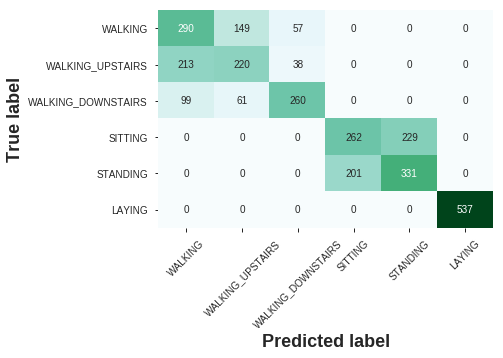

In [10]:
#@title Confusion Matrix
%matplotlib inline
cm = confusion_matrix(y_test, y_test_predict)
df_cm = pd.DataFrame(cm, index=[i for i in activity_labels], columns=[i for i in activity_labels])
plt.figure()
ax = sns.heatmap(df_cm,  cbar = False, cmap="BuGn", annot=True, fmt="d")
plt.setp(ax.get_xticklabels(), rotation=45)
plt.ylabel('True label', fontweight='bold', fontsize = 18)
plt.xlabel('Predicted label', fontweight='bold', fontsize = 18)
plt.show()

# Conclusion

As it can be seen in the confusion matrix, the misclassification was higher between WALKING UPSTAIRS vs WALKING DOWNSTAIRS vs WALKING and SITTING vs STANDING. Dynamic activities, due to their distinct motion characteristics and cyclic behaviour, were clearly discriminated against static activities.

# Improvements

In [31]:
#@title Add more signals

# Load data
y_train_sig = np.loadtxt('UCI HAR Dataset/train/Inertial Signals/total_acc_y_train.txt', dtype='float32')
y_test_sig = np.loadtxt('UCI HAR Dataset/test/Inertial Signals/total_acc_y_test.txt', dtype='float32')
z_train_sig = np.loadtxt('UCI HAR Dataset/train/Inertial Signals/total_acc_z_train.txt', dtype='float32')
z_test_sig = np.loadtxt('UCI HAR Dataset/test/Inertial Signals/total_acc_z_test.txt', dtype='float32')
import numba      


@numba.jit
def magnitude(all_sig):
  mag_train = []
  for i in range(len(all_sig[0])):
    mag_row= []
    for j in range(len(all_sig[0][i])):
        mag_row.append(np.sqrt(all_sig[0][i,j]**2 + all_sig[1][i,j]**2 + all_sig[2][i,j]**2))
    mag_train.append(mag_row)
  
  return np.array(mag_train)

## Data Preparation
@numba.jit
def extract_sig(dir, sig_name, mag=True):
  feat = pd.DataFrame()
  all_sig = []
  for idx_d, d in enumerate(dir):
    sig = np.loadtxt(d, dtype='float32')
    XMag_test = tsfel.extract_features(cfg_file, sig, fs=100)
    feat = pd.concat([feat, XMag_test], axis=1)
    if mag:
      all_sig.append(sig)
      if idx_d == 2 or idx_d == 5 or idx_d == 8:
        _mag = magnitude(all_sig)
        feat_mag = tsfel.extract_features(cfg_file, _mag, fs=100)
        feat = pd.concat([feat, feat_mag], axis=1)
        all_sig=[]
  return feat


dir = ['UCI HAR Dataset/train/Inertial Signals/total_acc_x_train.txt', 'UCI HAR Dataset/train/Inertial Signals/total_acc_y_train.txt', 'UCI HAR Dataset/train/Inertial Signals/total_acc_z_train.txt', 
       'UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt', 'UCI HAR Dataset/train/Inertial Signals/body_acc_y_train.txt', 'UCI HAR Dataset/train/Inertial Signals/body_acc_z_train.txt',
      'UCI HAR Dataset/train/Inertial Signals/body_gyro_x_train.txt', 'UCI HAR Dataset/train/Inertial Signals/body_gyro_y_train.txt', 'UCI HAR Dataset/train/Inertial Signals/body_gyro_z_train.txt']
sig_name = ['tot_x', 'tot_y', 'tot_z','tot_mag', 'body_x', 'body_y', 'body_z', 'body_mag',
           'gyr_x', 'gyr_y', 'gyr_z', 'gyr_mag']
X_train = extract_sig(dir, sig_name, mag=True)

dir = ['UCI HAR Dataset/test/Inertial Signals/total_acc_x_test.txt', 'UCI HAR Dataset/test/Inertial Signals/total_acc_y_test.txt', 'UCI HAR Dataset/test/Inertial Signals/total_acc_z_test.txt', 
       'UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt', 'UCI HAR Dataset/test/Inertial Signals/body_acc_y_test.txt', 'UCI HAR Dataset/test/Inertial Signals/body_acc_z_test.txt',
      'UCI HAR Dataset/test/Inertial Signals/body_gyro_x_test.txt', 'UCI HAR Dataset/test/Inertial Signals/body_gyro_y_test.txt', 'UCI HAR Dataset/test/Inertial Signals/body_gyro_z_test.txt']
X_test = extract_sig(dir, sig_name, mag=True)

## Feature Selection
# Concatenation of entire data
names = [Xt.replace(" ", "_") for Xt in X_train.columns]
features = pd.concat([X_train, X_test], names=names)
# Highly correlated features are removed
#features = tsfel.correlation_report(features)
X_train = features[:len(X_train)]
X_test = features[len(X_train):]

# Classification
classifier = DecisionTreeClassifier()
# Train the classifier
classifier.fit(X_train, y_train.ravel())
# Predict test data
y_test_predict = classifier.predict(X_test)

# Get the classification report
accuracy = accuracy_score(y_test, y_test_predict)*100
print(classification_report(y_test, y_test_predict))
print("Accuracy: " + str(accuracy) + '%')

*** Feature extraction started ***
*** Feature extraction finished ***
*** Feature extraction started ***
*** Feature extraction finished ***
*** Feature extraction started ***
*** Feature extraction finished ***
*** Feature extraction started ***
*** Feature extraction finished ***
*** Feature extraction started ***
*** Feature extraction finished ***
*** Feature extraction started ***
*** Feature extraction finished ***
*** Feature extraction started ***
*** Feature extraction finished ***
*** Feature extraction started ***
*** Feature extraction finished ***
*** Feature extraction started ***
*** Feature extraction finished ***
*** Feature extraction started ***
*** Feature extraction finished ***
*** Feature extraction started ***
*** Feature extraction finished ***
*** Feature extraction started ***
*** Feature extraction finished ***
*** Feature extraction started ***
*** Feature extraction finished ***
*** Feature extraction started ***
*** Feature extraction finished ***
*** Fe

In [32]:
#@title Try more classifiers

import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

labels = np.concatenate([y_train, y_test])
# Finds best supervised learning classifier
classifier = tsfel.find_best_slclassifier(features, labels, X_train, X_test, y_train, y_test)

Nearest Neighbors
Accuracy: 0.786 (+/- 0.051)
Accuracy: 78.79199185612488%
-----------------------------------------
Decision Tree
Accuracy: 0.852 (+/- 0.065)
Accuracy: 84.5266372582287%
-----------------------------------------
Random Forest
Accuracy: 0.802 (+/- 0.056)
Accuracy: 78.41873091279267%
-----------------------------------------
AdaBoost
Accuracy: 0.539 (+/- 0.008)
Accuracy: 53.10485239226331%
-----------------------------------------
Naive Bayes
Accuracy: 0.855 (+/- 0.055)
Accuracy: 82.9317950458093%
-----------------------------------------
QDA
Accuracy: 0.832 (+/- 0.086)
Accuracy: 84.5266372582287%
-----------------------------------------
******** Best Classifier: Decision Tree ********


In [33]:
#@title Feature Selection
# Feature Selection
classifier = DecisionTreeClassifier(max_depth=5, min_samples_split=len(features)//10)
best_features_args = tsfel.forward_feature_selection(classifier, np.array(X_train), y_train, groups=None, cv=10, n_jobs=-1, feature_names=list(X_train.columns))

X_train = np.array(X_train)[:, best_features_args]
X_test = np.array(X_test)[:, best_features_args]

# Train the classifier
classifier.fit(X_train, y_train.ravel())

# Predict test data
y_test_predict = classifier.predict(X_test)
print('\n')

# Get the classification accuracy
accuracy = accuracy_score(y_test, y_test_predict)*100
scores = cross_val_score(classifier, np.concatenate([X_train,X_test]), labels, cv=10)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
print("Accuracy: " + str(accuracy) + '%')
print(classification_report(y_test, y_test_predict))

Selecting the best features...
Number of splits: 10
Accuracy: 65.57 +/- 4.52 ['0_Max']
Accuracy: 83.29 +/- 4.88 ['0_Max' '0_Mean']
Accuracy: 87.11 +/- 2.64 ['0_Max' '0_Mean' '0_Spectral kurtosis']
Accuracy: 87.81 +/- 3.36 ['0_Max' '0_Mean' '0_Spectral kurtosis' '0_Standard Deviation']
Accuracy: 87.99 +/- 3.23 ['0_Max' '0_Mean' '0_Spectral kurtosis' '0_Standard Deviation'
 '0_Interquartile range']
Accuracy: 88.08 +/- 3.28 ['0_Max' '0_Mean' '0_Spectral kurtosis' '0_Standard Deviation'
 '0_Interquartile range' '0_Interquartile range']
Accuracy: 88.14 +/- 3.34 ['0_Max' '0_Mean' '0_Spectral kurtosis' '0_Standard Deviation'
 '0_Interquartile range' '0_Interquartile range' '0_Median']
Accuracy: 88.18 +/- 3.35 ['0_Max' '0_Mean' '0_Spectral kurtosis' '0_Standard Deviation'
 '0_Interquartile range' '0_Interquartile range' '0_Median' '0_Median']
Accuracy: 88.21 +/- 3.36 ['0_Max' '0_Mean' '0_Spectral kurtosis' '0_Standard Deviation'
 '0_Interquartile range' '0_Interquartile range' '0_Median' '0_Me